# Introduction to PyTorch

- [PyTorch](http://pytorch.org/) it's a framework for developing and training neural networks. 
- It's very similar to numpy, but here, `array` is called `tensors`
- `tensors` make the communication between CPU and GPU much easier than `arrays`
- also, pytorch has usefull functions to calculate gradients (which is great for backpropagation tasks) and build neural networks
- compared with tensorflow and other frameworks, pytorch is better to work with python / numpy / scipy

Simple machine learning models (e.g. like perceptron, and linear and logistic regression) must solve linear equations like:

$$
\begin{align}
y &= f(w_1 x_1 + w_2 x_2 + b) \\
y &= f\left(\sum_i w_i x_i +b \right)
\end{align}
$$

representing with vectors:

$$
h = \begin{bmatrix}
x_1 \, x_2 \cdots  x_n
\end{bmatrix}
\cdot 
\begin{bmatrix}
           w_1 \\
           w_2 \\
           \vdots \\
           w_n
\end{bmatrix}
$$


## Tensors

- Linear algebra with `tensors`, matrix genaralization, and other math areas are  exactly what machine algorithms do..
   - vector is a 1D tensor
   - matrix is a 2D tensor
   - a 3D array is a 3D tensor (e.g. RBG images)


In [2]:
import torch

In [3]:
def activation_function_sigmoid(x):
    """ Defining the activation function - Sigmoid
    
        Args:
        ---------
        x: torch.Tensor
        return: Sigmoid f(x)
    """
    return 1/(1+torch.exp(-x))

In [4]:
### GENERATING RANDOM DATA
torch.manual_seed(7) # Setting the seed for replicable results

# creating a tensor with 1 line (because we have only 1 sample) and 5 columns (5 features per sample), 
features = torch.randn((1, 5))     #   torch.randn ---> normal distribution with mean=0 and variance=1

# generating wandom weights for the model: randn_like 
weights = torch.randn_like(features)   # it generates other tensors with the same characteristics of "features"

# BIAS term - it's a tensor with only 1 line and 1 column
bias = torch.randn((1, 1))

In [5]:
print('features:', features)
print('weights: ', weights)
print('bias:    ', bias)

features: tensor([[-0.1468,  0.7861,  0.9468, -1.1143,  1.6908]])
weights:  tensor([[-0.8948, -0.3556,  1.2324,  0.1382, -1.6822]])
bias:     tensor([[0.3177]])


* Just like `arrays`, `tensors` can be added, subtracted, multiplied, etc.
* the advantage here, it that we can use the GPU 

## Example: computing the output of a neuron model

In [6]:
### HOW TO PREDICT THE OUTPUT OF THE NEURON:

# Just like numpy, we can use torch.sum(), assim como o métodos .sum() nos tensores.

# torch.sum(w * f + b) which is the 1st degree equation
y1 = activation_function_sigmoid(torch.sum(features * weights) + bias)
print('option 1: ', y1)

# .sum()
y2 = activation_function_sigmoid((features * weights).sum() + bias)
print('option 2: ', y2)

# or we can multiply the matrixes (+effective, especially with GPUs) using torch.mm() or torch.matmul()
#  torch.mm()
y3 = activation_function_sigmoid(torch.mm(features, weights.view(5,1)) + bias)
print('option 3: ', y3)

option 1:  tensor([[0.1595]])
option 2:  tensor([[0.1595]])
option 3:  tensor([[0.1595]])


- As we can see, we have here 3 ways of getting to the same result!
- Note that in 3rd option, we had to reshape our tensor weights by calling 'view(5,1)'
- The error would be `RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x5 and 1x5)`
- To reshape our vector, we can use:

    1) `tensor.shape`

    2) `tensor.reshape()`

    3) `tensor.resize_()`

    4) `tensor.view()`

In [7]:
torch.mm(features, weights)   # ERROR: just to show how it  would be if we didnt reshape the tensor weights

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x5 and 1x5)

## Converting between Numpy **and** Pytorch

In [8]:
import numpy as np
# generating a random numpy array of 4 lines and 3 columns
a = np.random.rand(4,3)
a

array([[0.59791751, 0.83459349, 0.28437374],
       [0.82464193, 0.4631071 , 0.5142315 ],
       [0.13498697, 0.85068501, 0.23941607],
       [0.77132713, 0.76865881, 0.23185548]])

In [9]:
# Converting to tensor
b = torch.from_numpy(a)
b

tensor([[0.5979, 0.8346, 0.2844],
        [0.8246, 0.4631, 0.5142],
        [0.1350, 0.8507, 0.2394],
        [0.7713, 0.7687, 0.2319]], dtype=torch.float64)

In [10]:
# converting back to numpy
b.numpy()

array([[0.59791751, 0.83459349, 0.28437374],
       [0.82464193, 0.4631071 , 0.5142315 ],
       [0.13498697, 0.85068501, 0.23941607],
       [0.77132713, 0.76865881, 0.23185548]])

In [11]:
# if we change an object 'inplace', we change both objects
# so, if we multiply 'b' by 2, in-place (passing the inplace version of mul: 'mul_')
b.mul_(2)
print(b)
print(a)

tensor([[1.1958, 1.6692, 0.5687],
        [1.6493, 0.9262, 1.0285],
        [0.2700, 1.7014, 0.4788],
        [1.5427, 1.5373, 0.4637]], dtype=torch.float64)
[[1.19583502 1.66918699 0.56874748]
 [1.64928385 0.9262142  1.028463  ]
 [0.26997393 1.70137001 0.47883215]
 [1.54265425 1.53731761 0.46371095]]


## Linear Regression with PyTorch


In [12]:
import torch
from torch.autograd import Variable   # variable that will be altered by gradient descent
from torch.nn import functional as F

In [13]:
# checking if the PyTorch version is using GPU
print('PyTorch version: ', torch.__version__)
print('Using GPU: ', torch.cuda.is_available())

if torch.cuda.is_available():    
    print('GPU: ',torch.cuda.get_device_name(torch.cuda.current_device()))

PyTorch version:  1.9.0
Using GPU:  False


- At this moment, I'm not using a GPU so the message was `False`
### Generating random samples

In [14]:
x_data = Variable(torch.Tensor([[10.0], [9.0], [3.0], [2.0]]))
y_data = Variable(torch.Tensor([[90.0], [80.0], [50.0], [30.0]]))
x_data

tensor([[10.],
        [ 9.],
        [ 3.],
        [ 2.]])

### Configuring the class of our Linear Regression model
- which will inherit from `torch.nn.Module`
- Defining `__init__`: which inherit from the super and we add a linear layer `self.linear` with 1 feature and 1 output
- Weights and bias are inside the layer, that why we don't define them again
- Method `forward`: pass the instructions of the model from the input to the output
- Linear function is very simple, so we receive $x$ and predict a value ($\hat{y}$) for $y$.

In [15]:
class LinearRegression(torch.nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(1, 1)  #first is the number of features, second is number of output
    
    # the define our forward method, we must pass x to predict y
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

# instantiating the model    
model = LinearRegression()

### Loss function (Criterion)

- After executing the method `forward`, the loss function is used to compute how far if $\hat{y}$ from $y$
- With this loss function we can make some adjustments in the weights to get that difference closest to 0
- We will use _Mean Square Error (MSE)_, commonly used at regression tasks.

### Optimizer _Stochastic Gradient Descent (SGD)_
- This optimizer will be used to update the weights of the model
- the function `model.parameters()` tells our optimizer which weights will be updated
- `lr` tells us what's going to be the learning rate


In [16]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

### Trainning the model
after the forward step, we modify the weights by backpropagation

### Backpropagation
1) Random weights
2) Epochs: partial 
   - partial derivative of each weight for each layer
   - forward step calculates the function of each neuron (a)
   - backward
   - each neuron loss is calculated
   - accumulate each partial derivative
   - Mean Gradient
   - Use Gradient Descent to update the weights
   - evaluate the loss function **J**

In [18]:
#difining for how many epochs we will pass our model
epochs = 20

for epoch in range(epochs):
    model.train()
       # Zero the gradients at each epoch (using backpropagation)
    optimizer.zero_grad()
       # Forward pass
    y_pred = model(x_data)
       # Computa o erro
    loss = criterion(y_pred, y_data)
       # propagate error to the previous layers
    loss.backward()
       # Atualiza os pesos
    optimizer.step()

### Making predictions

In [20]:
new_x = Variable(torch.Tensor([[4.0]]))
y_pred = model(new_x)
print("estimated value: ", float(y_pred.data[0][0]))

estimated value:  40.458919525146484


## Logistic Regression
- Using Fashion MNIST data 
- pixels : **28 x 28**
- 10 classes of each type (e.g.: 10 pants, 10 shoes, 10 shirts,...)

![MNIST](https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2018/05/04/ImagesSageMaker3.png)

## Transforms
- could be used for: 
   - regularization
   - transform to tensor
   - flip data (horizontal, vertical)
   - image from RGB ---> b/w

In [84]:
import torch
from torch.autograd import Variable

# transforms: we can use this to make some transformations in the original dataset
import torchvision.transforms as transforms
import torchvision.datasets as dsets

In [85]:
### Downloading datasets
# 60.000 train samples
# 10.000 test samples

train_dataset = dsets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.FashionMNIST(root='./data', train=False, transform=transforms.ToTensor())

### Creating data loaders 

In [86]:
batch_size = 100    # divide our 60.000 samples in 600 batches x 100 batch_size

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

input_dim = 784   # pixels 28 x 28 = 784 
output_dim = 10   # number of classes

### Creating the Logistic Regression's class
- inherit from `torch.nn.Module`
- `__init__` method inherit from super as well
- creating the linear parameter with input and output dimensions
- method `forward` that receives x and return the output

In [76]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs

### Defining hiperparameters

In [87]:
n_iters = 3000   #iterations at each batch (total 600 batches)
# defining the epochs: in this case, 3000 / (60.000 / 100)
epochs = n_iters / (len(train_dataset) / batch_size)
#input_dim = 784
#output_dim = 10
lr_rate = 0.001  # learning rate

### Loss function
- Cross-Entropy (CE), which is close to Maximum Likelihood Estimation (MLE)

### update the weights
- using the optimizer _Stochastic Gradient Descent (SGD)_

In [88]:
model = LogisticRegression(input_dim, output_dim)
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

### Trainning the model

In [89]:
iter = 0
for epoch in range(int(epochs)):
             # getting the batches (from train_loader)
    for i, (images, labels) in enumerate(train_loader):
           # creating and resizing the image from the batch
        images = Variable(images.view(-1, 28 * 28))        # reshaping 1 vector of 784 dims
           # creating the labels also from batch
        labels = Variable(labels)                 # Variable: will be altered by gradient descent
           # must zero gradients for each epoch
        optimizer.zero_grad()
           # forward pass to compute each output
        outputs = model(images)
           # loss function: cross entropy
        loss = criterion(outputs, labels)
           # propagating the error by backward step
        loss.backward()
        optimizer.step()

        iter+=1
           # each time that iter has no remains when divided by 500, we get into this if
           ## and print the iteration time, loss and accuracy comparing to test_loader
        if iter%500==0:
            # calculate Accuracy
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = Variable(images.view(-1, 28*28))
                outputs = model(images)
                        # .max() gets the class with highest probability (between 10)
                _, predicted = torch.max(outputs.data, 1)
                total+= labels.size(0)
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
                correct+= (predicted == labels).sum()
            accuracy = 100 * correct.float()/total
            print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 1.5491256713867188. Accuracy: 64.05000305175781.
Iteration: 1000. Loss: 1.4081933498382568. Accuracy: 66.0.
Iteration: 1500. Loss: 1.2149624824523926. Accuracy: 66.63999938964844.
Iteration: 2000. Loss: 0.9995977282524109. Accuracy: 67.9000015258789.
Iteration: 2500. Loss: 0.9008254408836365. Accuracy: 68.80999755859375.
Iteration: 3000. Loss: 1.092545509338379. Accuracy: 69.9000015258789.


## Plotting random images from the dataset
- I tried using the method imshow from `helper` lib, but didn't worked
- So, the [solution](https://stackoverflow.com/questions/53570181/error-in-importing-libraries-of-helper-though-helper-is-installed) was to define a function to show the Tensor images
- also, when calling the second iterator i ran into an error.
- At [pytorch forum](https://discuss.pytorch.org/t/typeerror-int-object-is-not-callable-when-using-second-iterator/30312) was the solution:
   - replace `iter(object)` for `object.__iter__()`


In [96]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [104]:
len(train_loader)

600

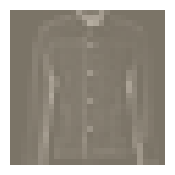

In [119]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(2,3))
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return plt.show()

image, label = next(train_loader.__iter__())
ax = imshow(image[0,:])

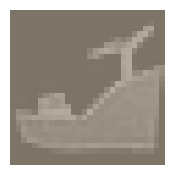

In [120]:
image, label = next(train_loader.__iter__())
ax = imshow(image[0,:])

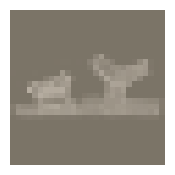

In [121]:
image, label = next(train_loader.__iter__())
ax = imshow(image[0,:])

## Estimating sample labels from test samples
- compute the accuracy and generate a confusion matrix

In [125]:
predicted_list = []
estimated_list = []

for images, labels in test_dataset:
    images = Variable(images.view(-1, 28*28))
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    # class 'torch.Tensor'
    predicted_list.append(predicted.item())
    estimated_list.append(labels)

In [126]:
import pandas as pd

estimations = pd.DataFrame(data={'predicted':predicted_list, 'estimated':estimated_list})
estimations.head()

,predicted,estimated
0,9,9
1,2,2
2,1,1
3,1,1
4,6,6


## Calculating the Accuracy

In [129]:
## accuracy will be the correct predictions divided by all predictions
accuracy = (estimations['predicted'] == estimations['estimated']).sum()/len(estimations)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 69.90%


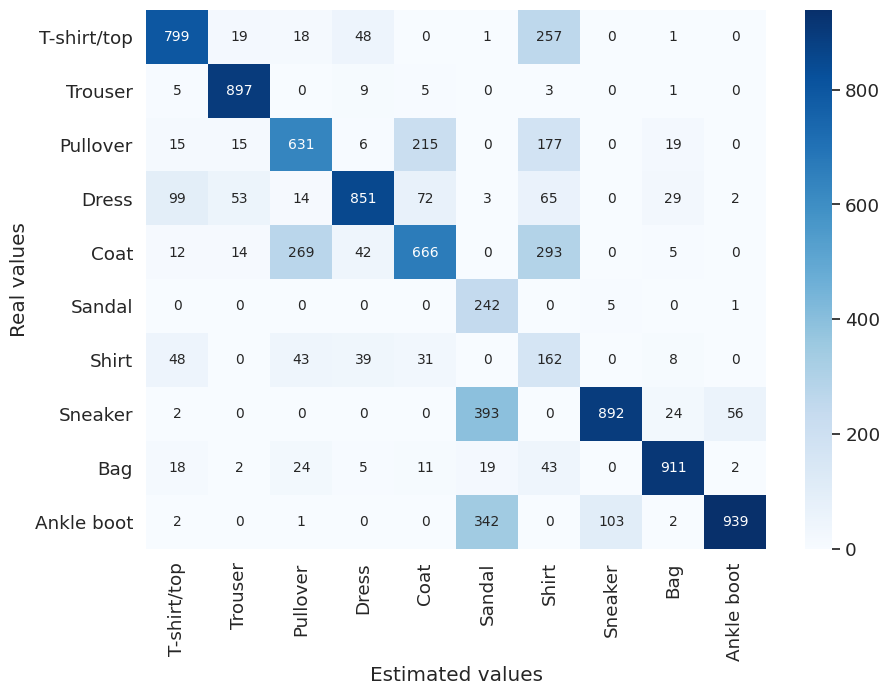

In [132]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

clothes_labels = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat',
                  5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'}

# instantiatin the confusion matrix
cm = confusion_matrix(predicted_list, estimated_list)

df_cm = pd.DataFrame(cm, columns=clothes_labels.values(), index=clothes_labels.values())
df_cm.index.name = "Real values"
df_cm.columns.name = "Estimated values"
plt.figure(figsize = (10,7))
sns.set(font_scale=1.2)
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt="d", annot_kws={"size": 10})
plt.show()